# 1. Copy and prepare raw data
In this section we simply copy and extract the zip files from the bucket to our VM. It is not possible to directly work with the data (there are workarounds, but not reccomended) on the Google Storage.

In [1]:
import google.datalab.storage as storage
import os

# See all the items we can fine
shared_bucket = storage.Bucket('carvana')
for obj in shared_bucket.objects():
  if obj.key.find('/') < 0:
    print(obj.key)

train_hq.zip
train_masks.zip


In [2]:
# Create some helper function for copying and unzipping
def maybe_copy(root, gs_location, zip_file):
  if os.path.exists(os.path.join(root, zip_file)):
    print("%s already copied.." % zip_file)
    return
  gs_loc = os.path.join(gs_location, zip_file)
  !gsutil cp $gs_loc $root
  
def maybe_unzip(root, zip_file):
  if os.path.exists(os.path.join(root, zip_file.split('.')[0])):
    print("%s already unzipped.." % zip_file)
    return
  zip_loc = os.path.join(root, zip_file)
  !unzip -qq $zip_loc -d $root

In [3]:
gs_location = 'gs://carvana'
root = '/content'

for obj in shared_bucket.objects():
  if obj.key.find('/') < 0:
    if obj.key.split('.')[1] == "zip":
      maybe_copy(root, gs_location, obj.key)
      maybe_unzip(root, obj.key)

train_hq.zip already copied..
train_hq.zip already unzipped..
train_masks.zip already copied..
train_masks.zip already unzipped..


# 2. View the images
Next, we get a feel for what the dataset looks like.

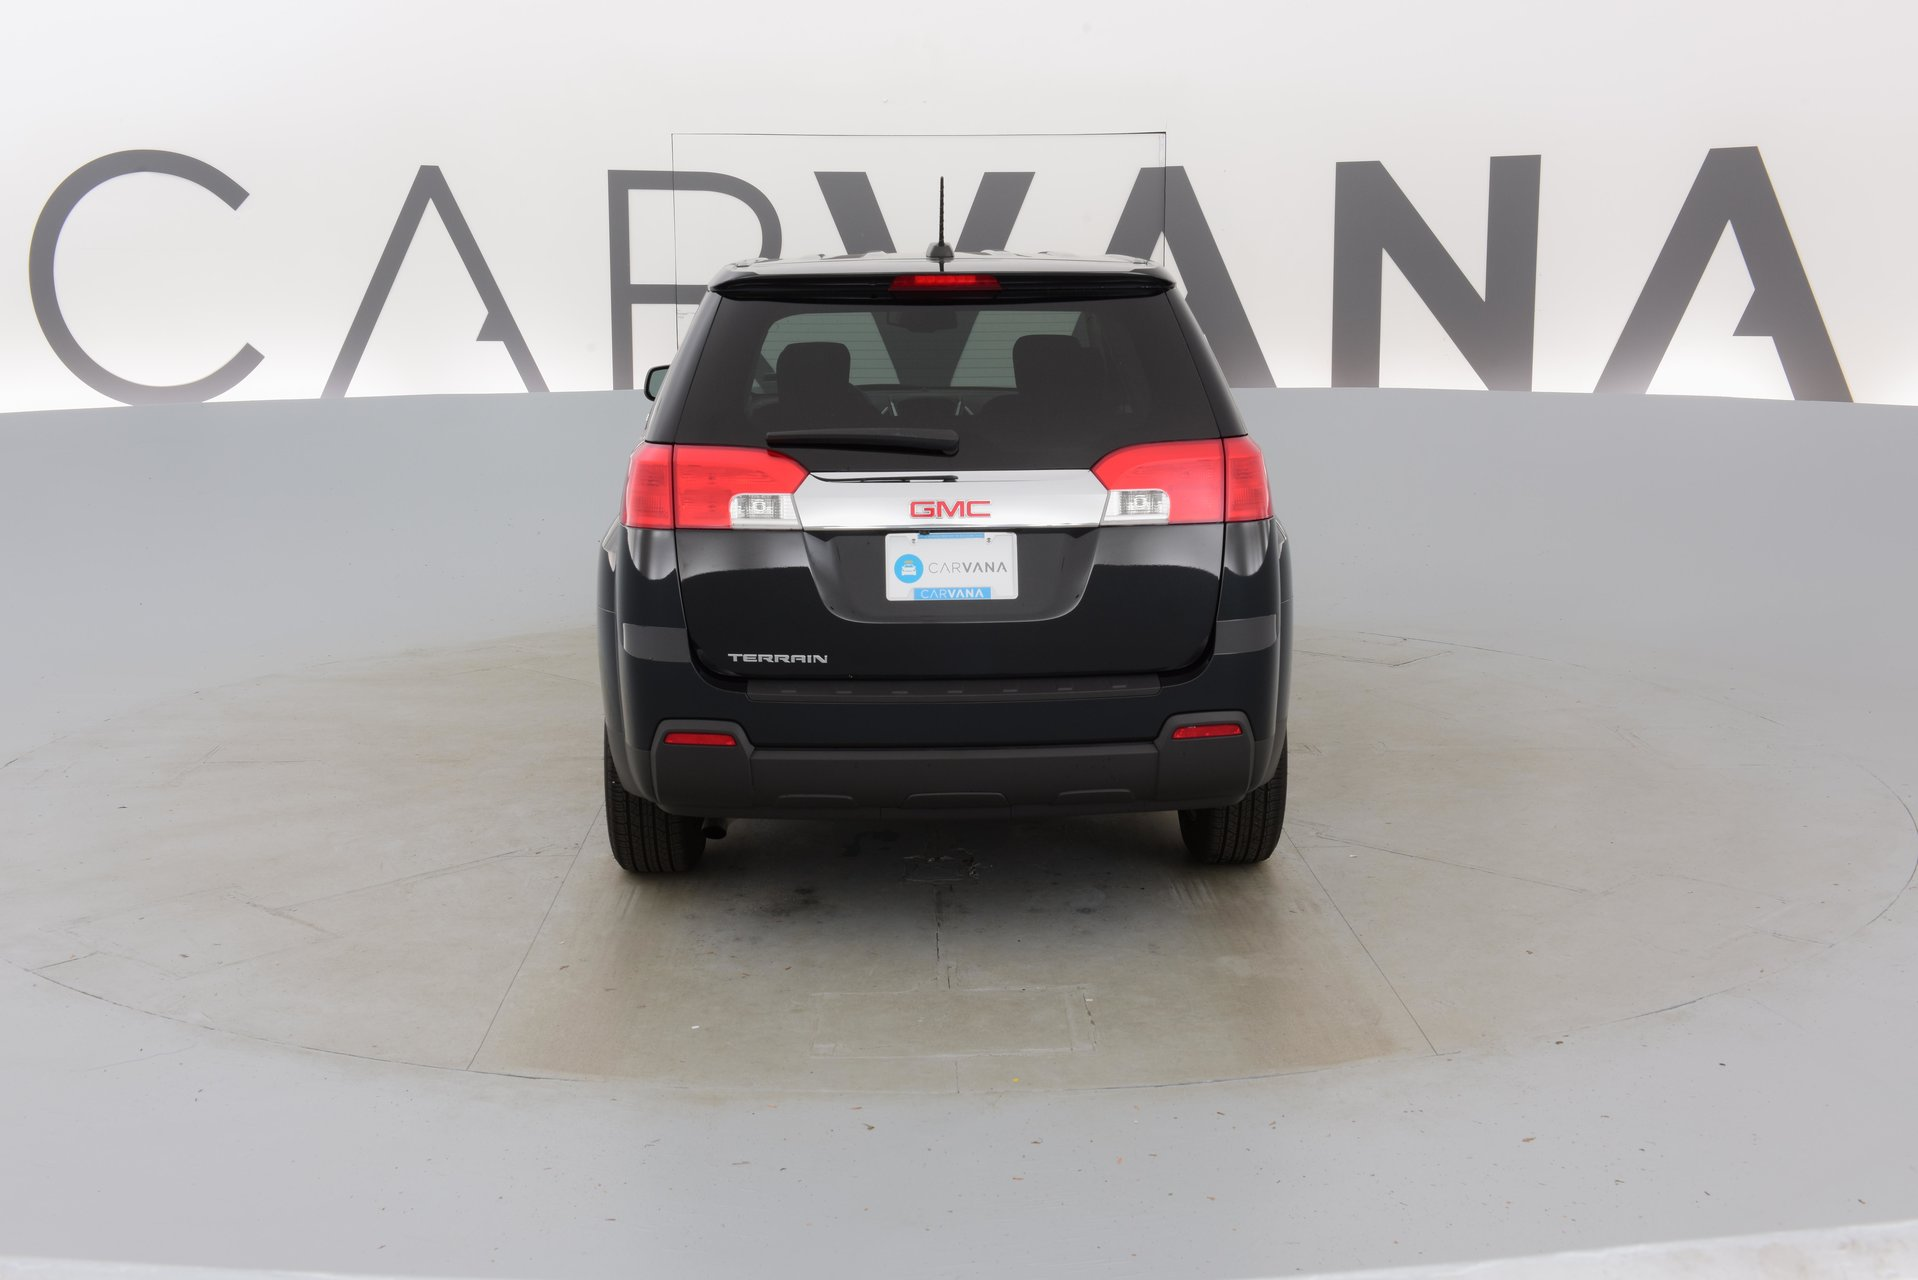

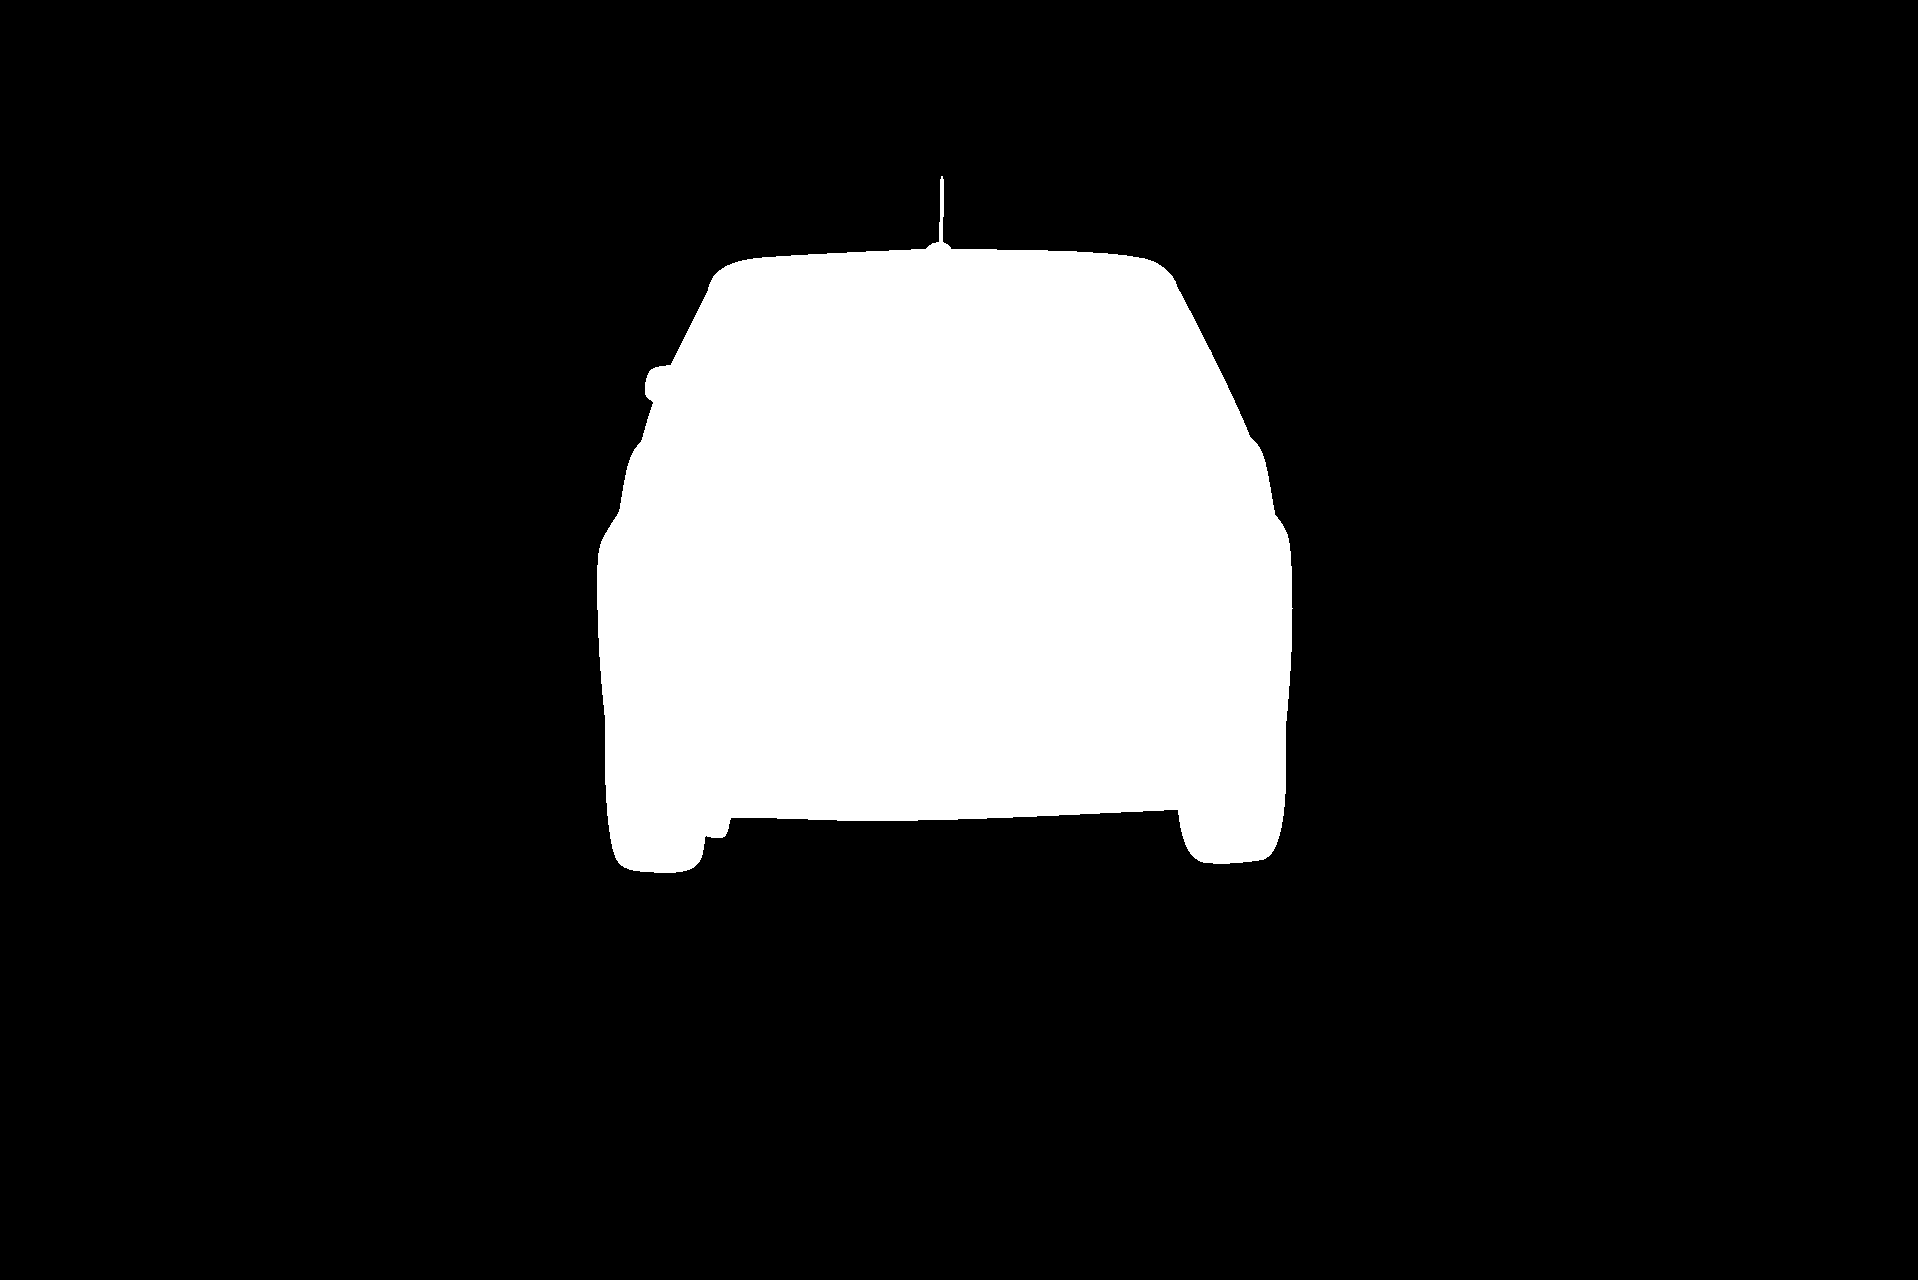

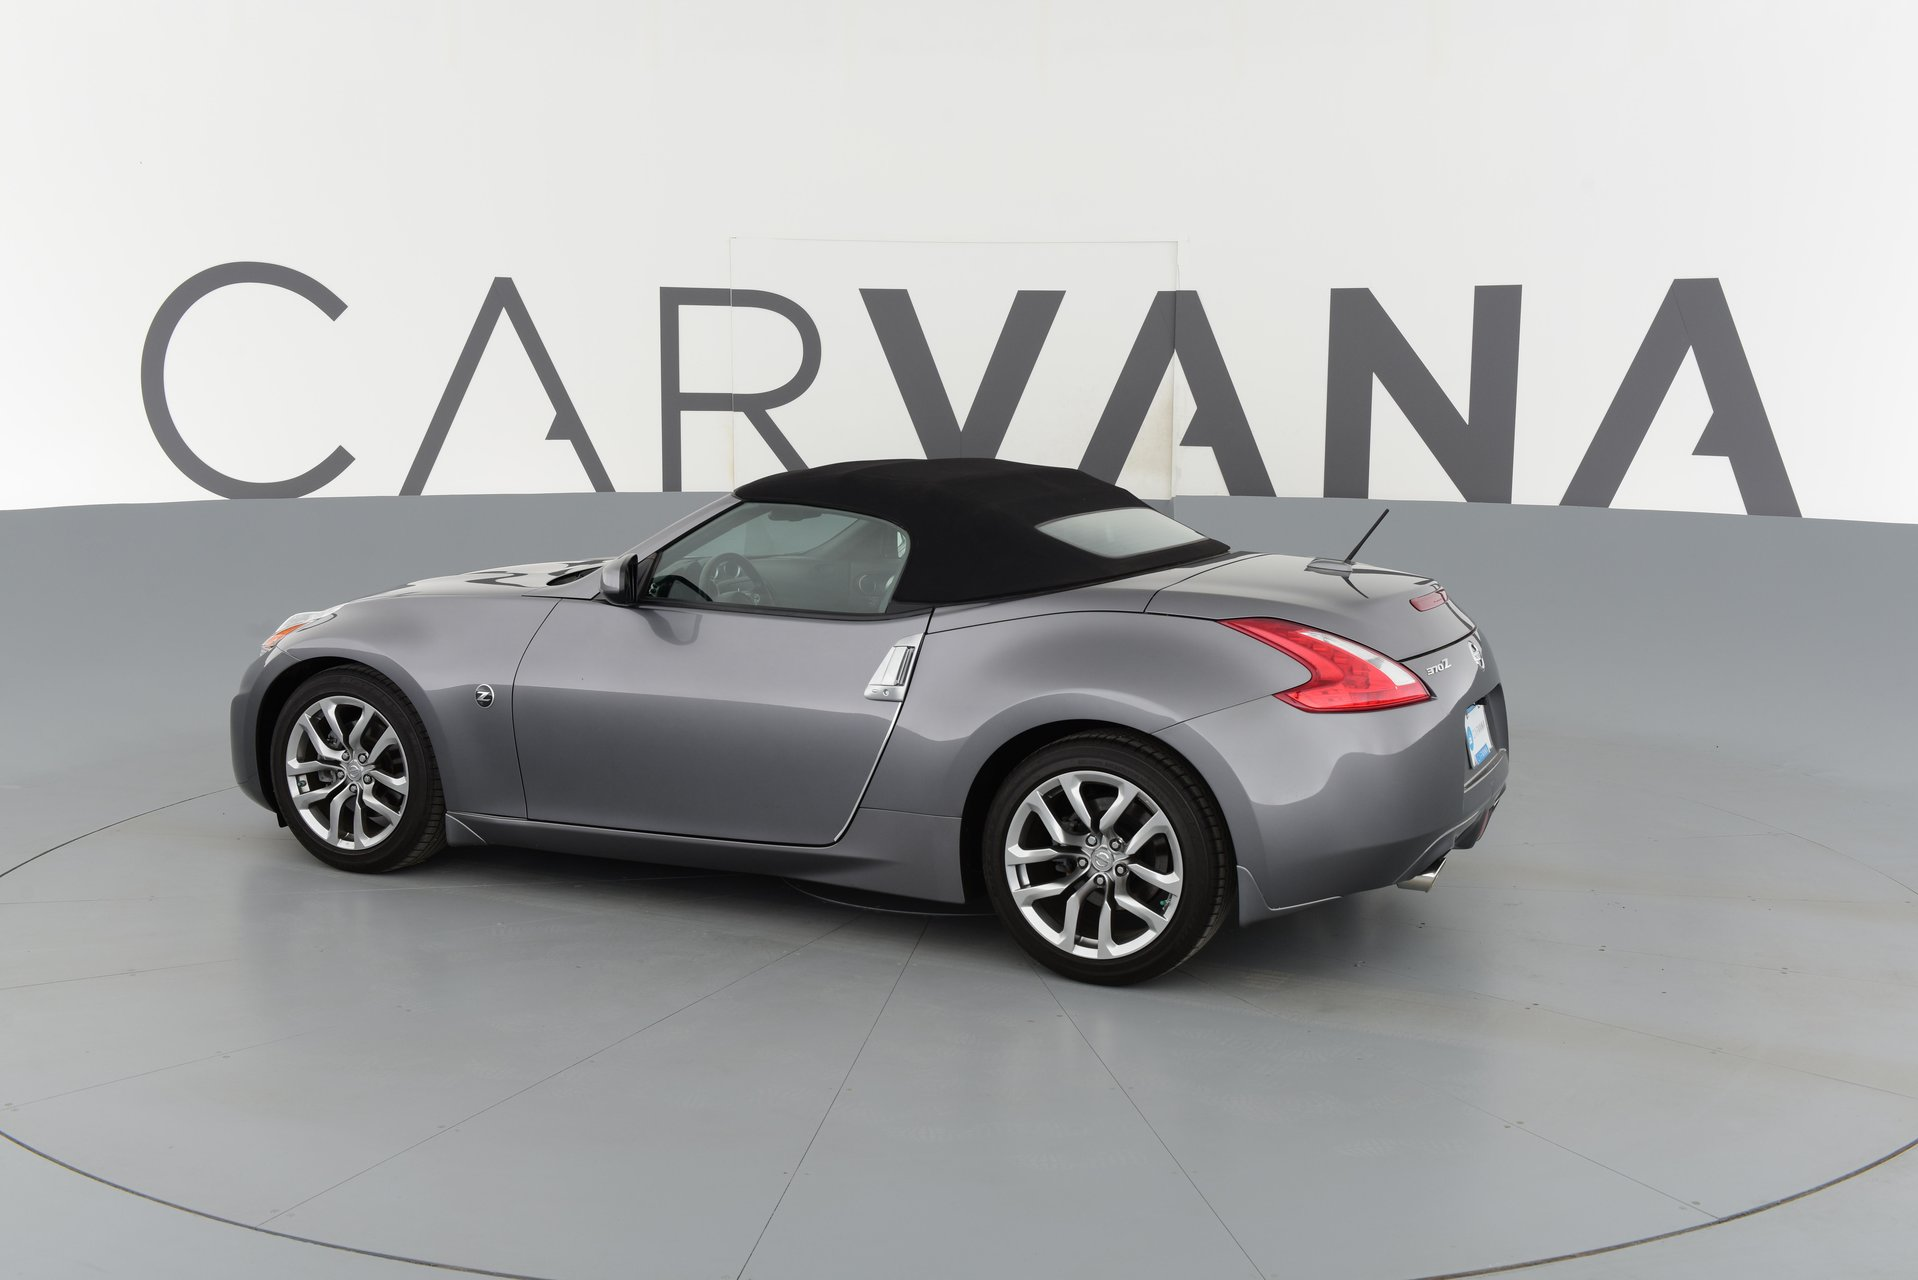

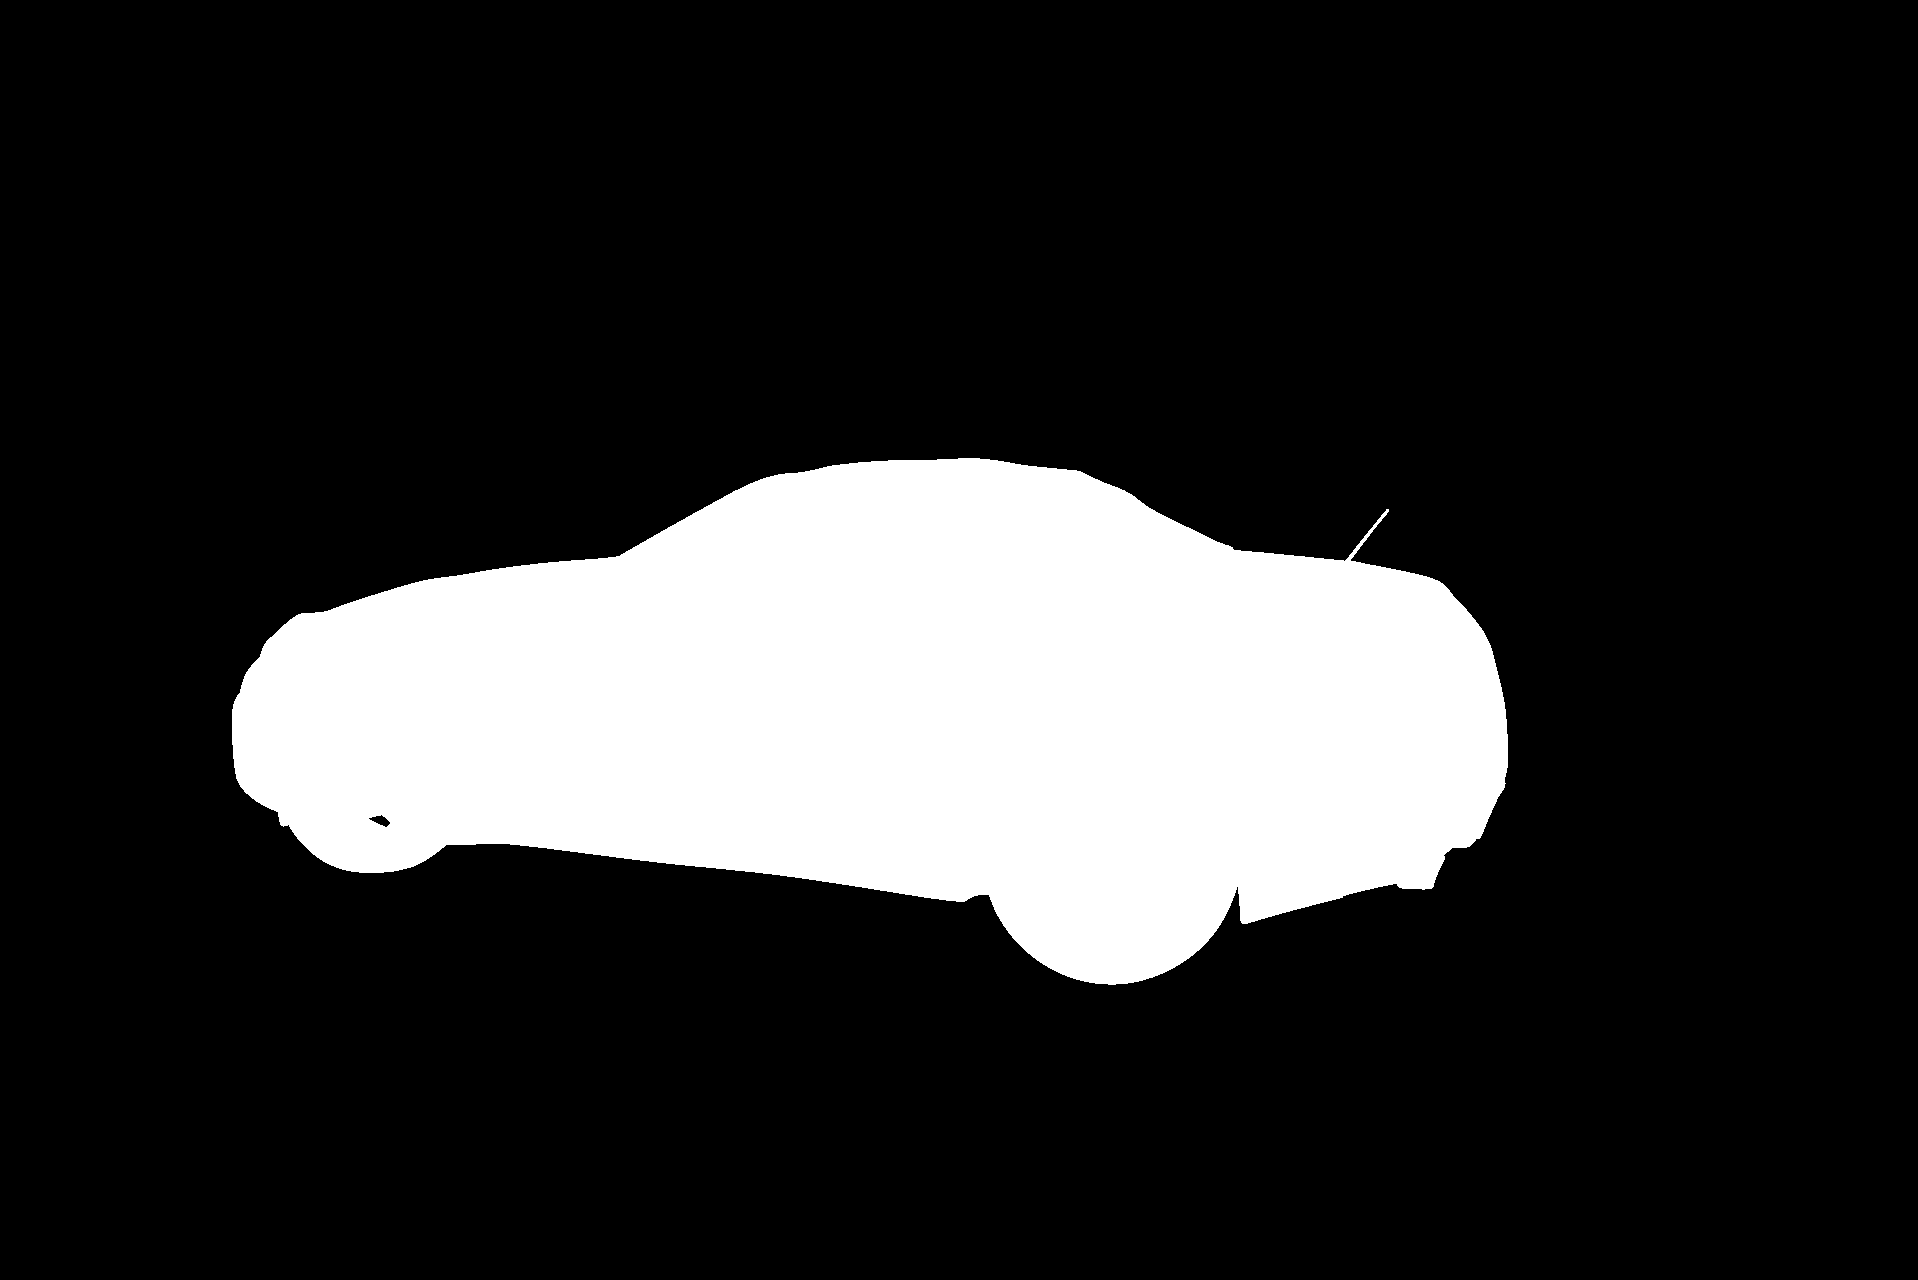

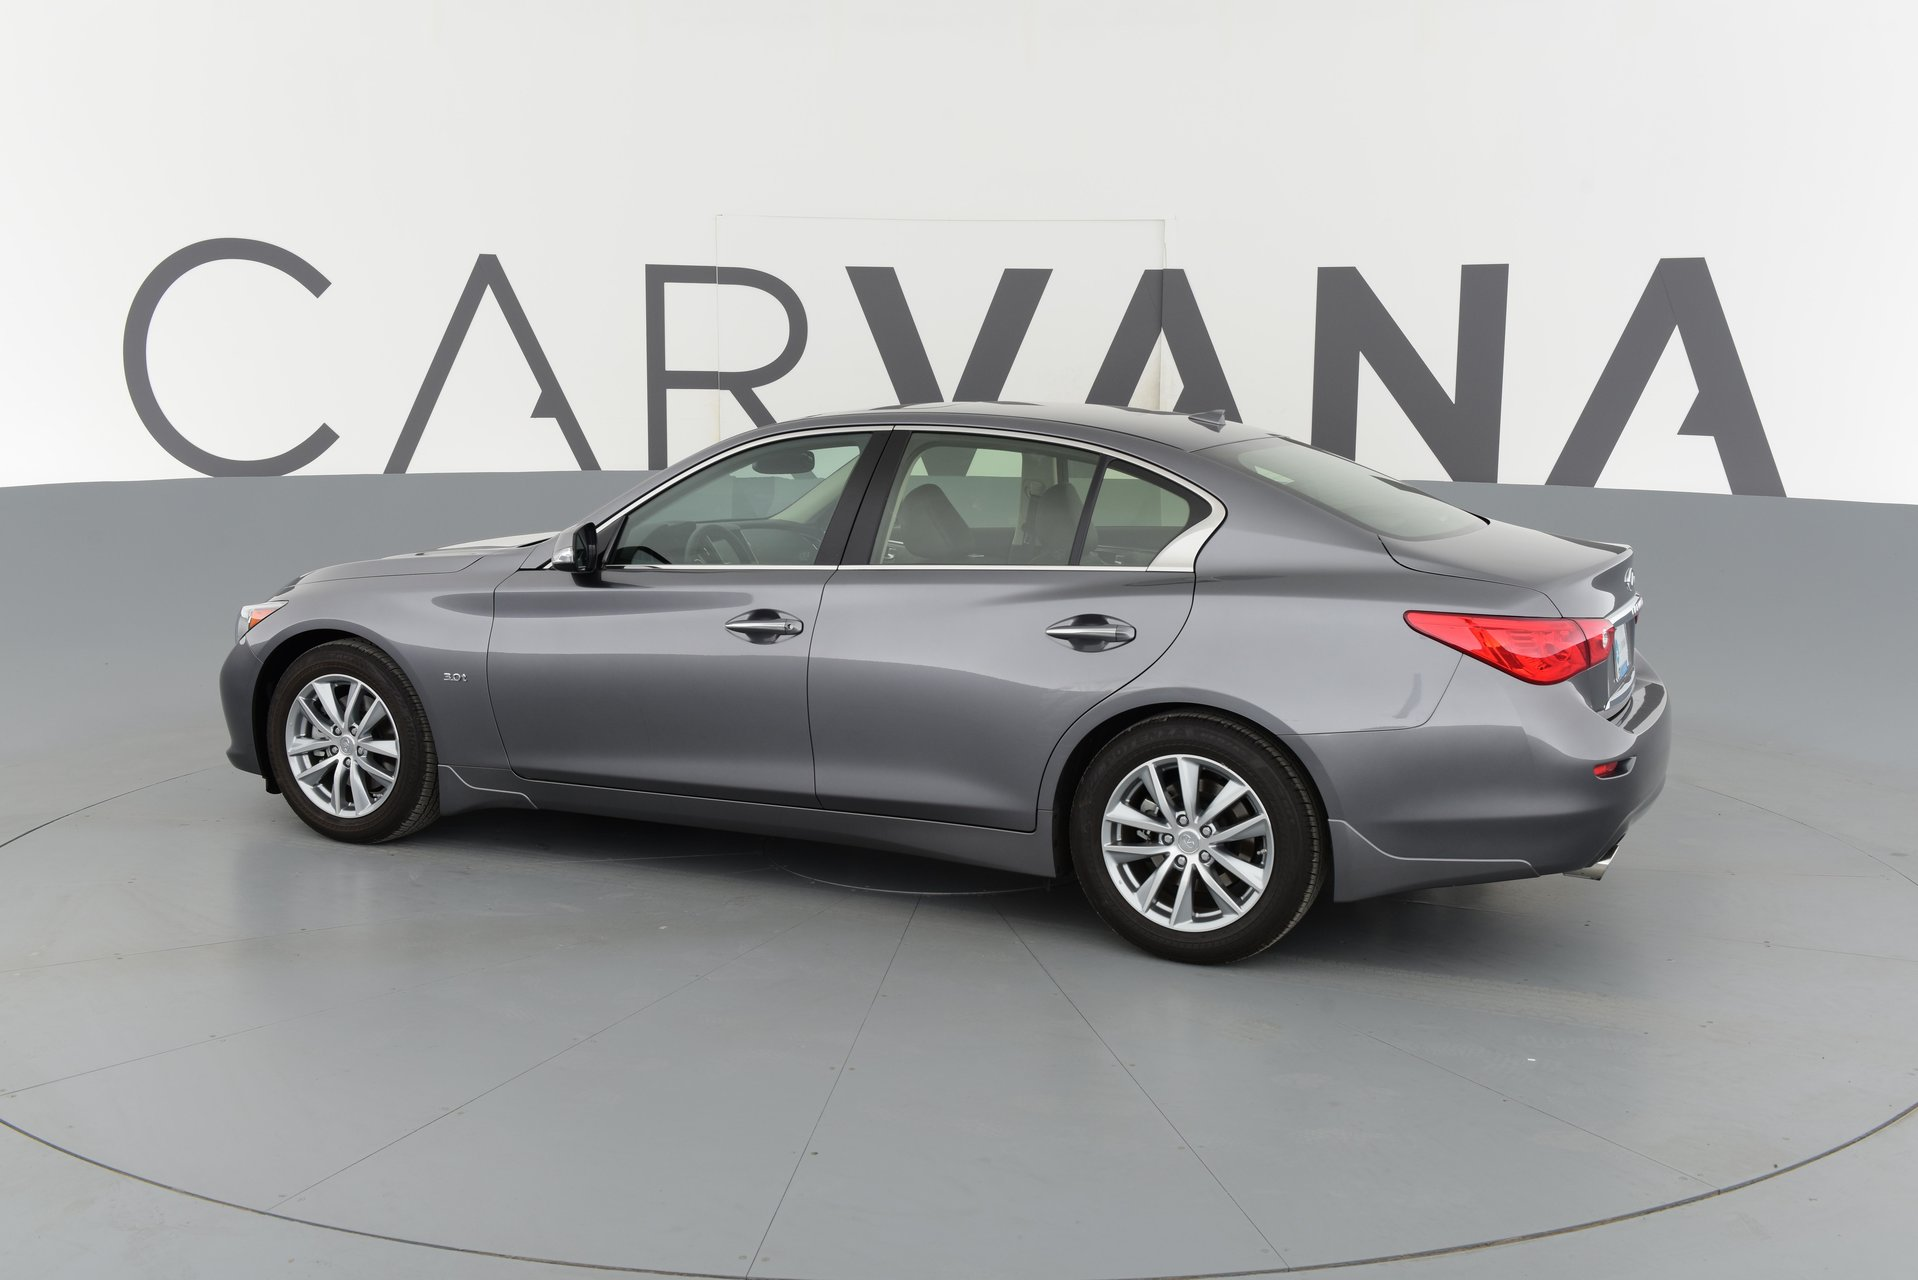

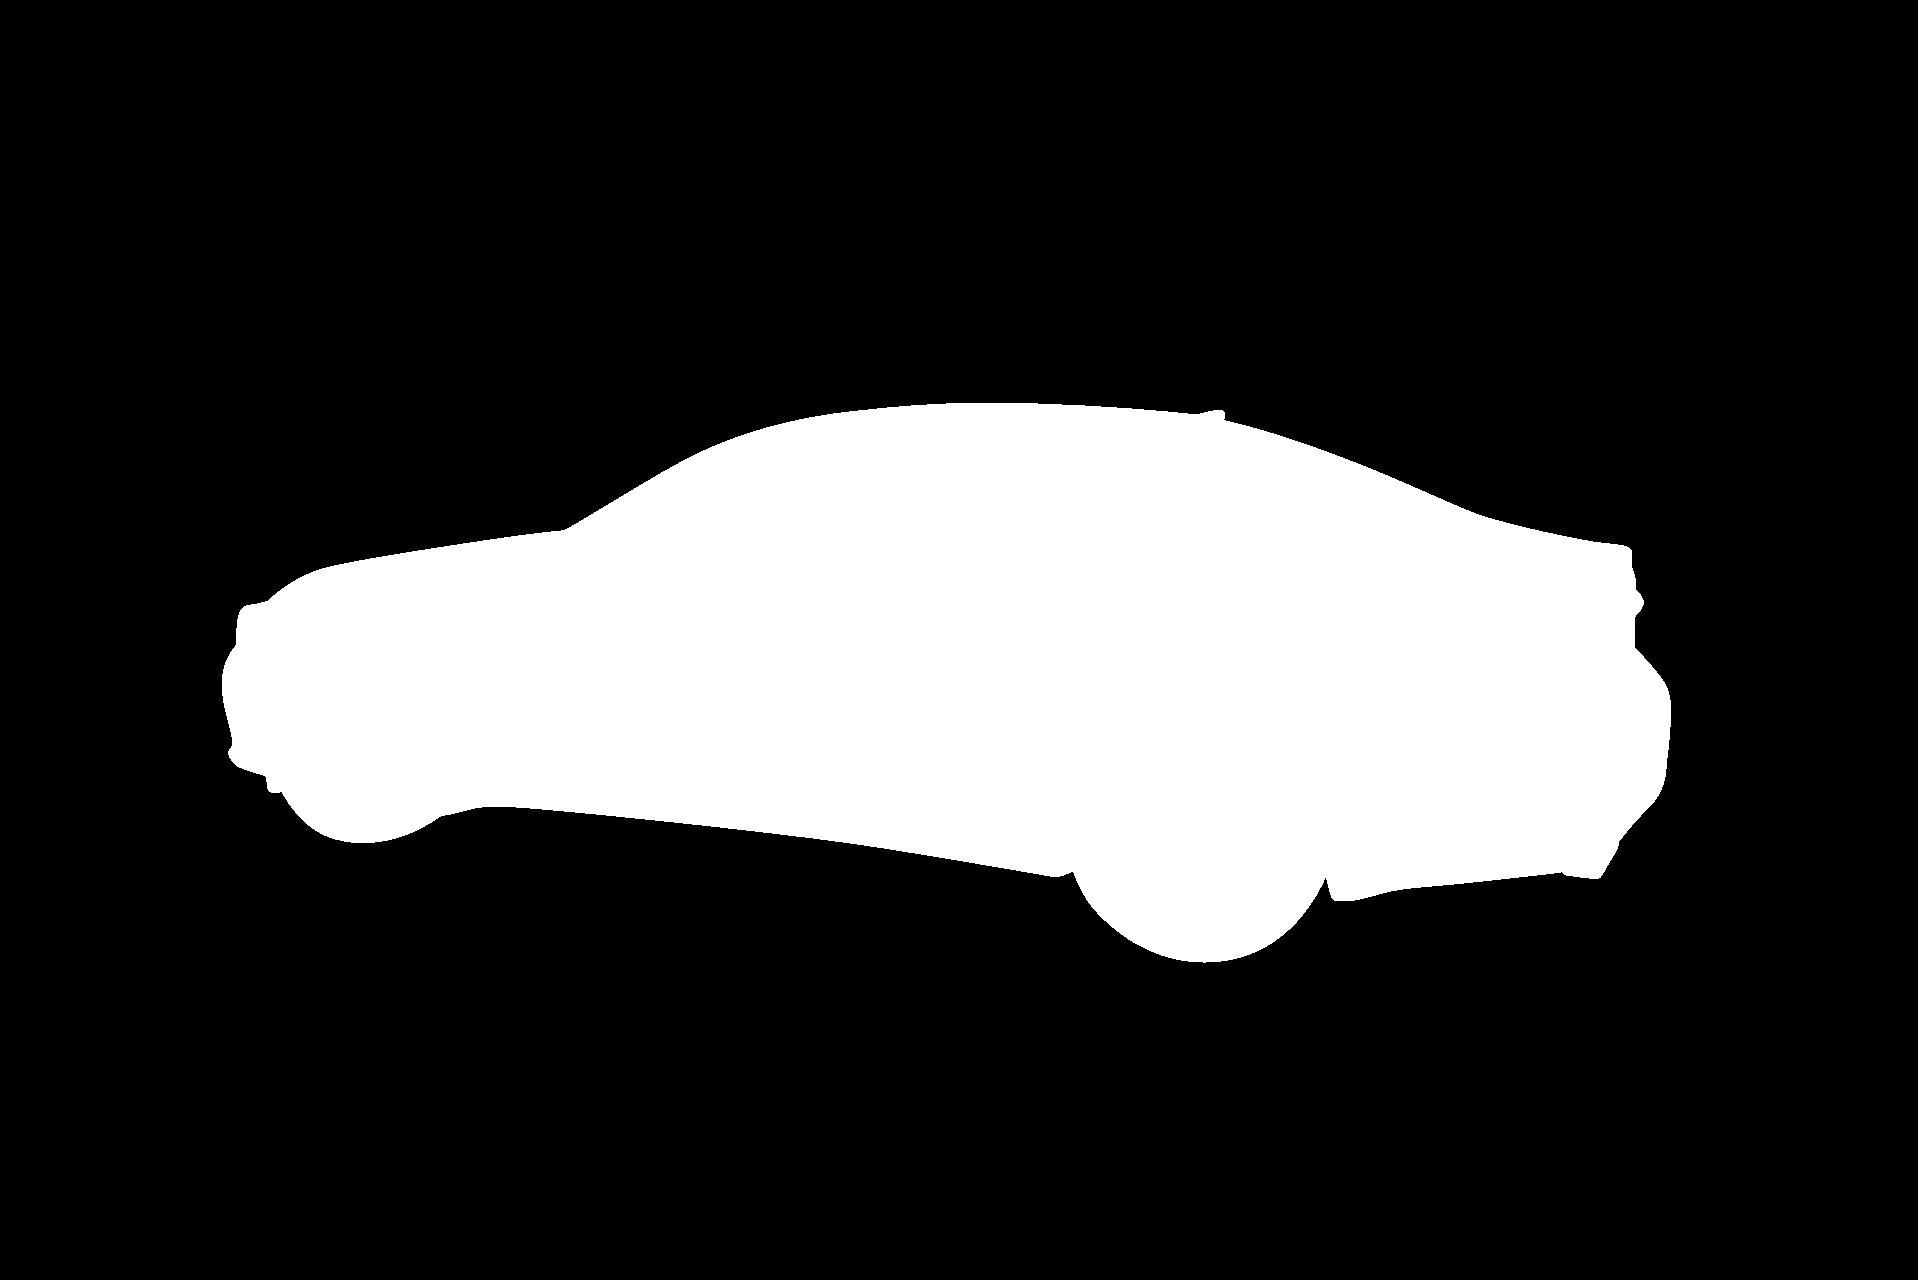

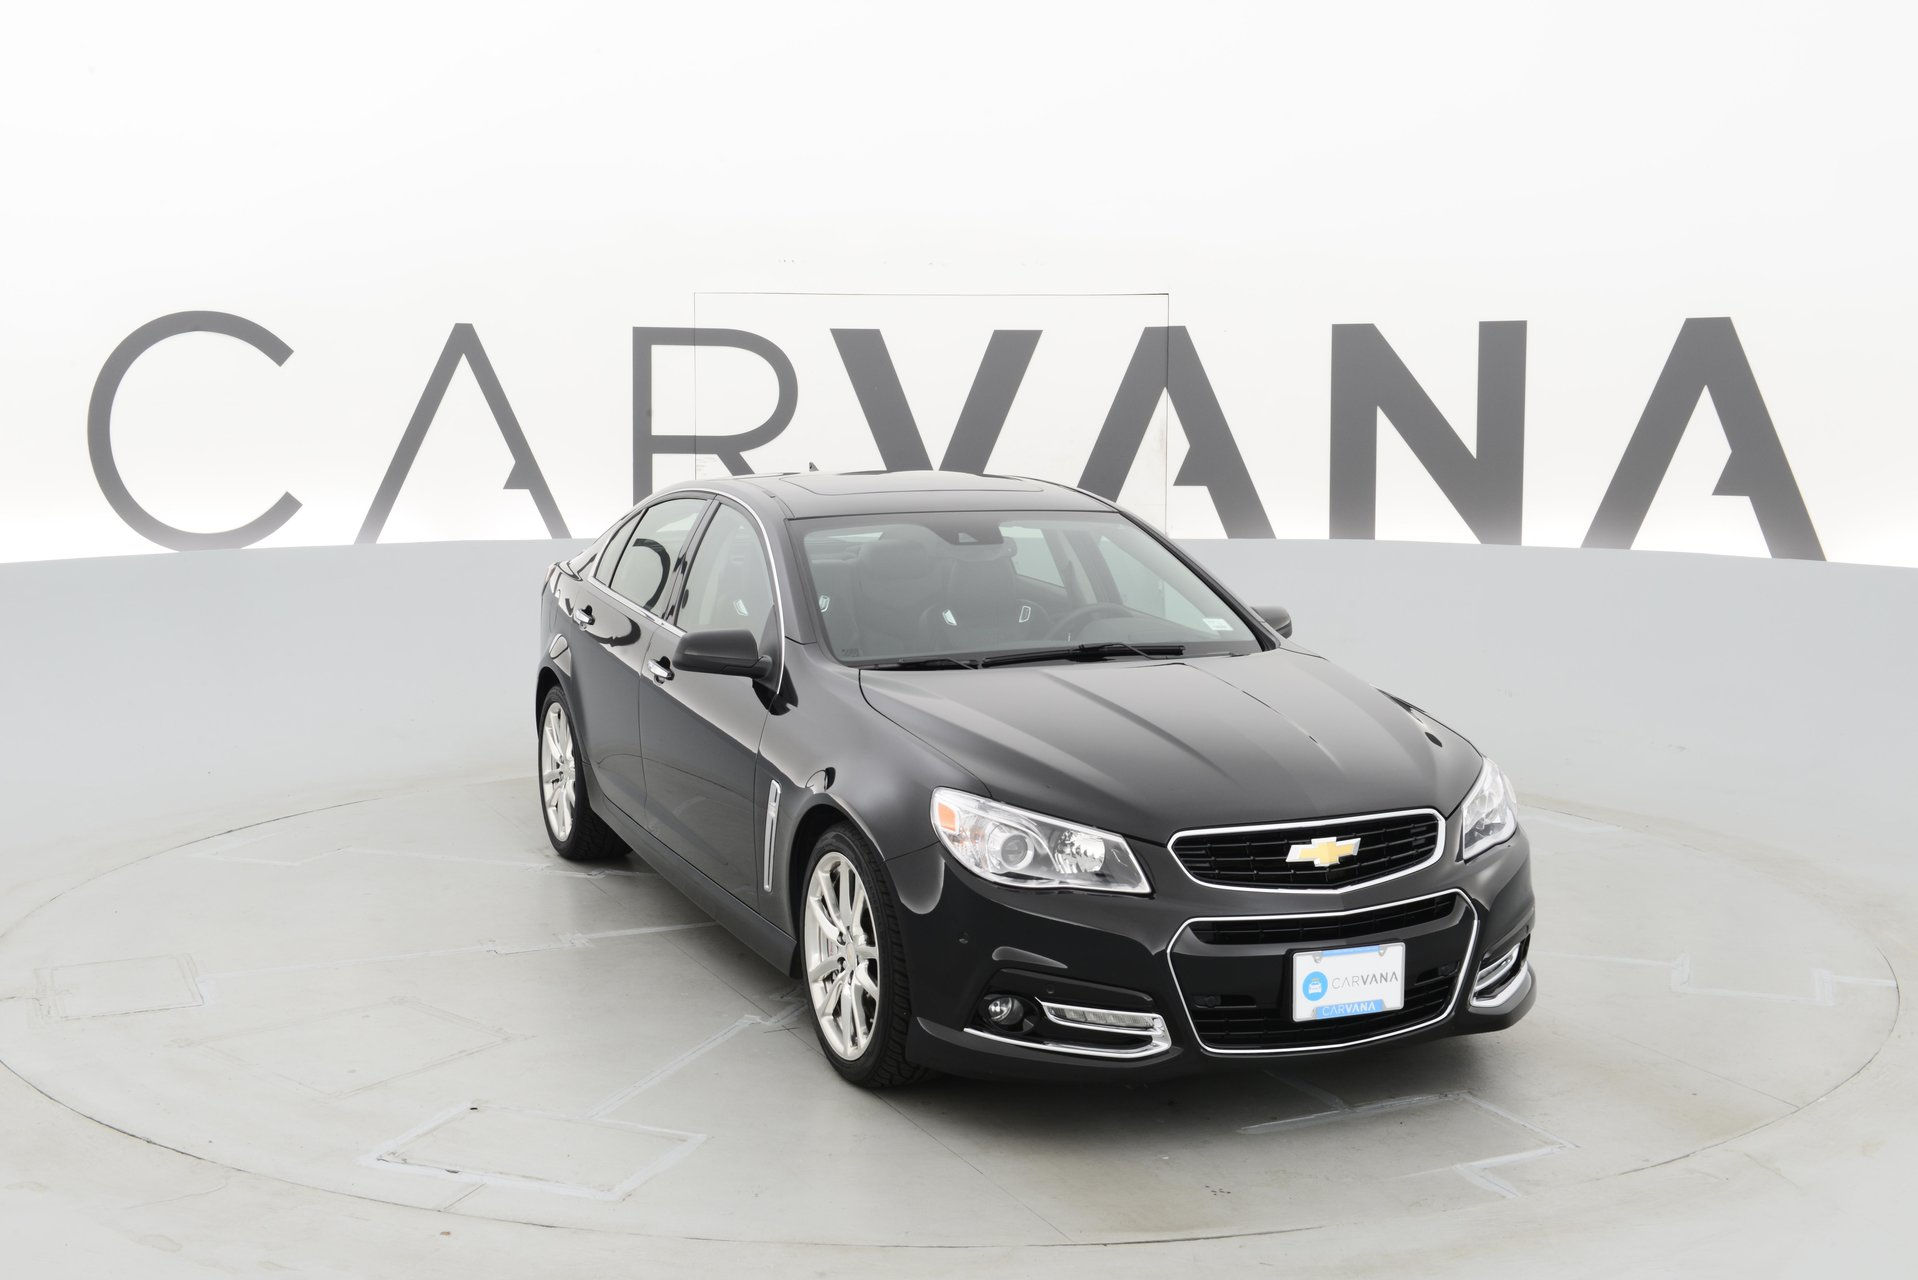

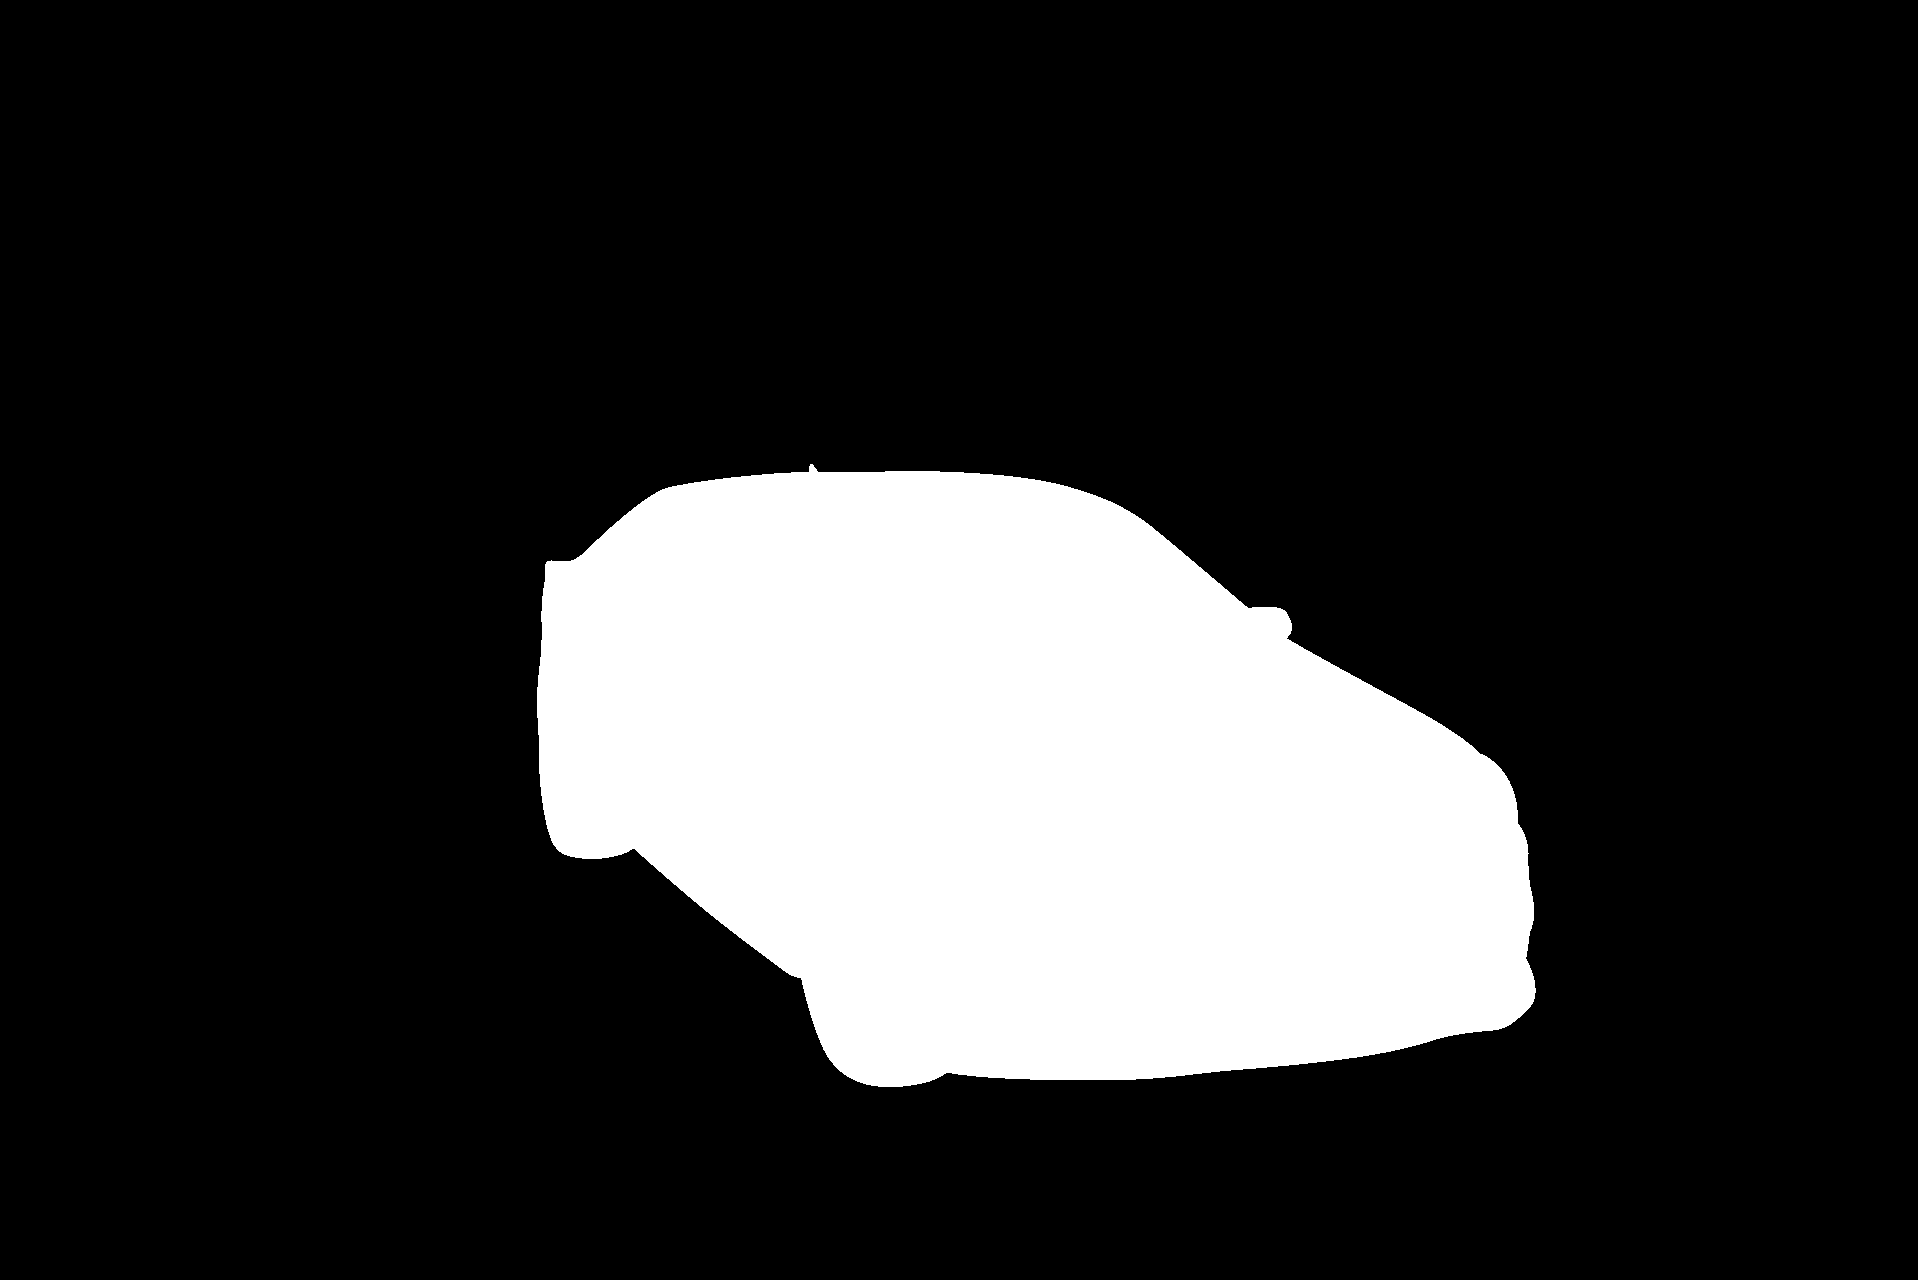

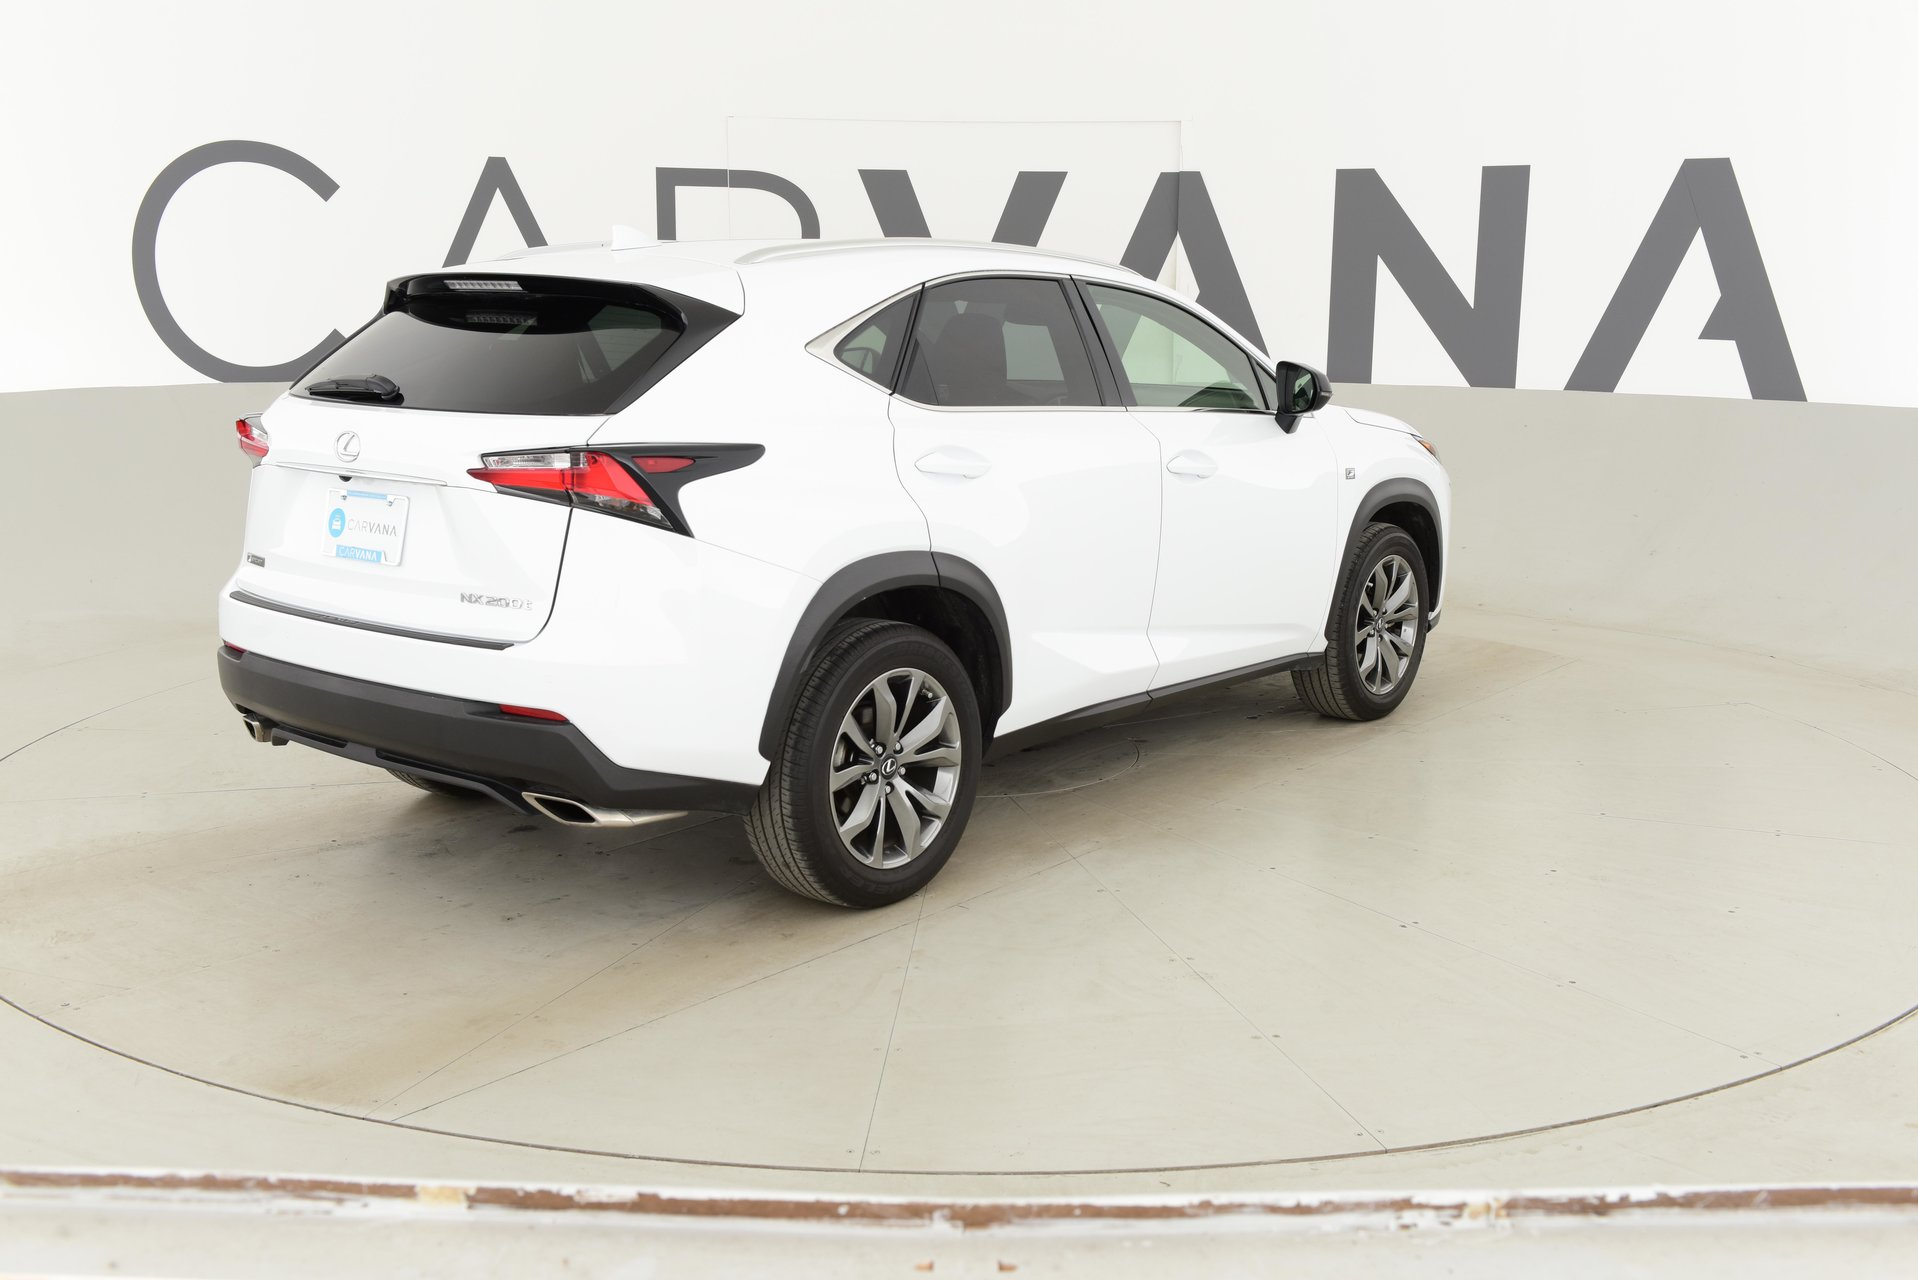

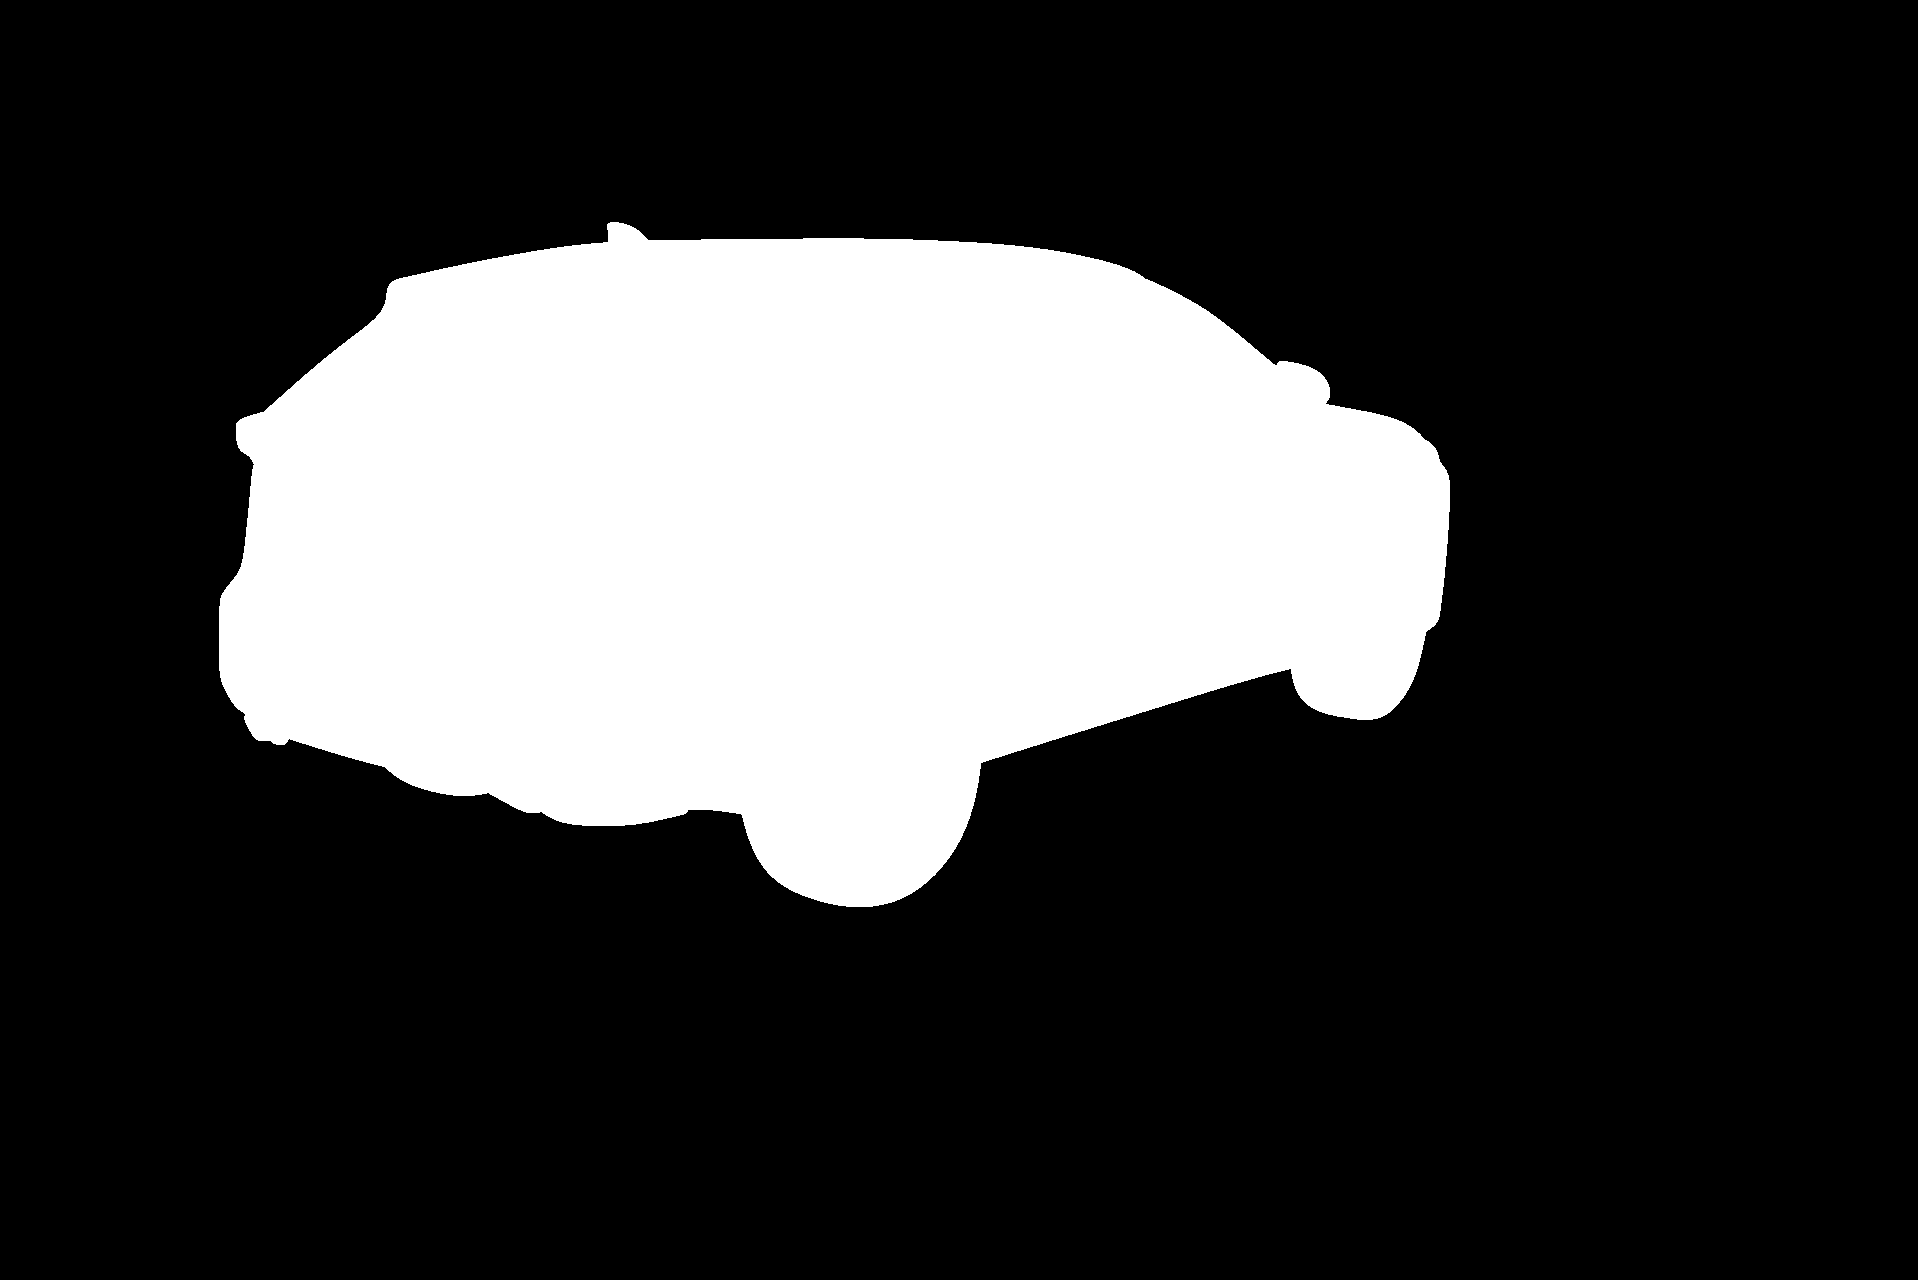

In [4]:
from IPython.display import Image 
from IPython.display import display
from random import shuffle

def yield_images(feature_root, mask_root, N):
  file_names = os.listdir(feature_root)
  shuffle(file_names)
  pairs = []
  for i, f in enumerate(file_names):
    pairs.append(os.path.abspath(os.path.join(feature_root, f)))
    pairs.append(os.path.abspath(os.path.join(mask_root, f.replace('.jpg', '_mask.gif'))))
    if i == N-1:
      break
  yield pairs

# Show N images
img_gen = yield_images(os.path.join(root, 'train_hq'), os.path.join(root, 'train_masks'), 5)
def display_these(list_of_images):
  img = []
  for i, image in enumerate(list_of_images):
    if i % 2:
      with open(image,'rb') as f:
        img.append(Image(data=f.read(), format='png', width=400))
        continue
    img.append(Image(image, width=400))

  display(*img)
  
# Get random images
display_these(next(img_gen))


# 3. Create TFRecords for the data
Now, we prepare for eventual training with the data. To speed up training we transform the images to a fileformat called .tfrecords.

This format is the reccomended format to use with Tensorflow. Of course, it is possible to work directly with .jpg files in a Queue,
but using TFRecords allows for faster reading from the disk, thus making it less likely that reading data from disk to be a bottleneck.

I have made a wrapper that will take as input the folders for the input image and corresponding mask, and create tfrecord which contain
both images within each "example". An example is the format of each segment of tfrecord. In this case our example is a pair of images
and their respective sizes.

In [7]:
from src.tfrecord.parsers import ImgImgParser

feature_img_folder = os.path.join(root, 'train_hq')
label_img_folder = os.path.join(root, 'train_masks')
split_ratio = [0.8, 0.1, 0.1]
my_parser = ImgImgParser('/content/tfrecords', feature_img_folder, label_img_folder, split_ratio, img_scale=0.25, randomize=True)

# Create records
my_parser.create_records(shards=10)

# List all files there
!ls -l /content/tfrecords


total 39536
-rw-r--r-- 1 root root  613346 Jan 17 08:33 test_shard_0.tfrecords
-rw-r--r-- 1 root root 4906768 Jan 17 08:33 train_shard_0.tfrecords
-rw-r--r-- 1 root root 4906768 Jan 17 08:33 train_shard_1.tfrecords
-rw-r--r-- 1 root root 4906768 Jan 17 08:33 train_shard_2.tfrecords
-rw-r--r-- 1 root root 4906768 Jan 17 08:33 train_shard_3.tfrecords
-rw-r--r-- 1 root root 4906768 Jan 17 08:33 train_shard_4.tfrecords
-rw-r--r-- 1 root root 4906768 Jan 17 08:33 train_shard_5.tfrecords
-rw-r--r-- 1 root root 4906768 Jan 17 08:33 train_shard_6.tfrecords
-rw-r--r-- 1 root root 4906768 Jan 17 08:33 train_shard_7.tfrecords
-rw-r--r-- 1 root root  613346 Jan 17 08:33 val_shard_0.tfrecords


# 4. Reading a TF Record
Reading a TFRecord has been made quite traight forward with the new Dataset API. The only thing one needs to provide is the "recipe" of the samples within the record, that is, the example format discussed above.

Here we make sure we can actually decode and visualize our TFRecords that we have created. I reccomend always doing this to make sure that your inputs are what you expect.

(320, 479, 3)
(4, 320, 479, 1)
(320, 479, 3)
(4, 320, 479, 1)
(320, 479, 3)
(4, 320, 479, 1)
(320, 479, 3)
(4, 320, 479, 1)


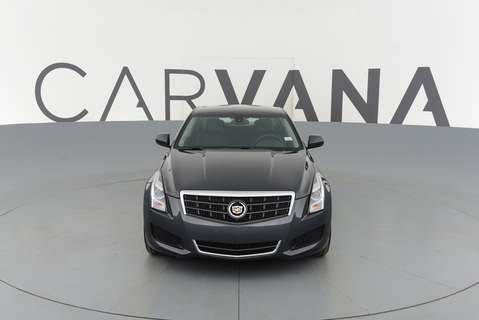

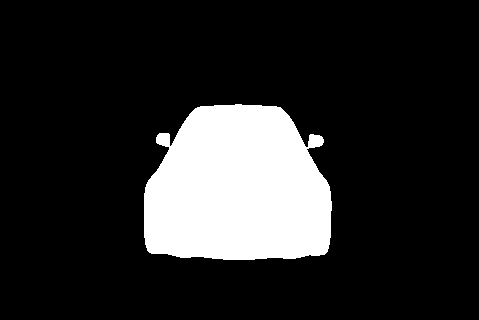

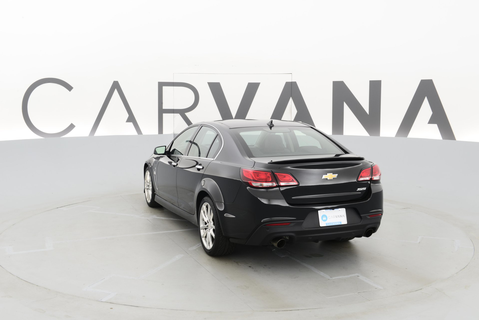

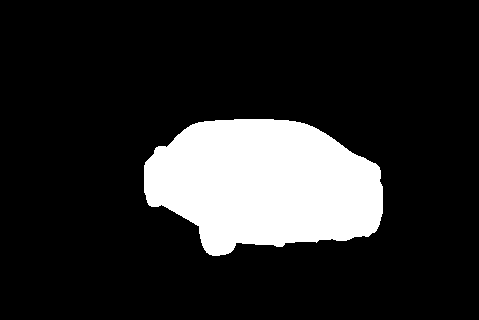

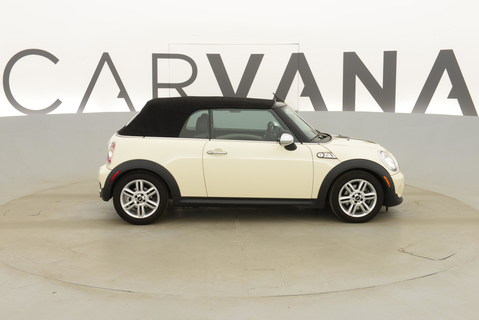

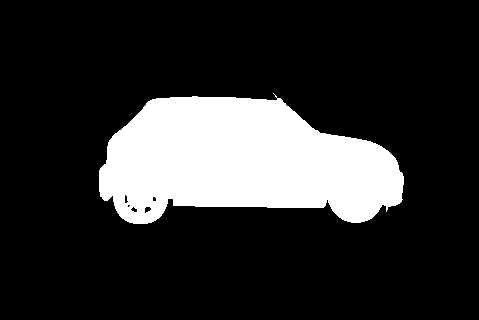

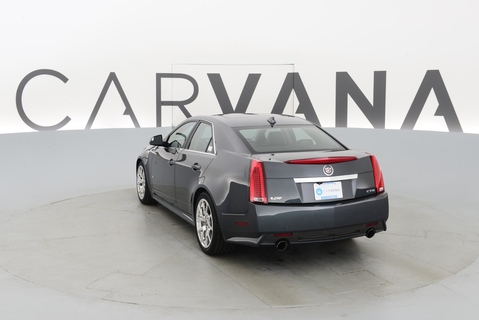

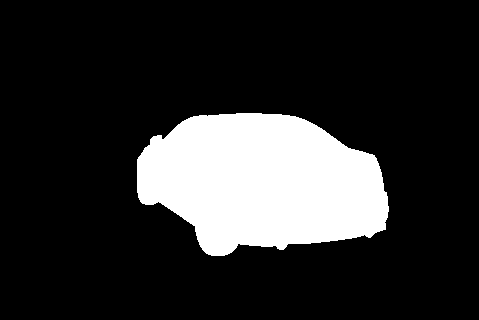

In [10]:
import tensorflow as tf
import numpy as np
import PIL.Image

feeder = my_parser.get_input_feeder('train', batch_size=4, buffer_size=2)

def rebuild_image(img):
  if img.dtype==np.int32:
    new_array = img.astype(np.uint8)*255
  else:
    new_array = ((img + 0.5)*255).astype(np.uint8)

  return PIL.Image.fromarray(new_array.squeeze())

feeder_gen = feeder()

with tf.Session() as sess:
    ftr_img, lbl_img = sess.run(feeder_gen)
    # Collect for plotting
    all_images = []
    for iFtr, iLbl in zip(ftr_img, lbl_img):
      print(iFtr.shape)
      print(lbl_img.shape)
      all_images += [rebuild_image(iFtr), rebuild_image(iLbl)]
    
    display(*all_images)
    